In [25]:
#!/usr/bin/env python

from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=4)
cluster


cluster

/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [26]:

client = Client(cluster)

client

Client Scheduler: tcp://10.32.15.48:39995 Dashboard: /user/0000-0001-7783-5629/proxy/35371/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [27]:
import xarray as xr
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import numpy as np                                                                                        
import zarr


In [28]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time
import gcsfs



In [29]:
%time

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)

mapzarr = gcs.get_mapper('pangeo-data/eNATL60-BLBT02X-ssh')
ds = xr.open_zarr(mapzarr)



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [30]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(240, 240, 480), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:29 +0100
    descr

In [31]:
g = zarr.open_group(mapzarr)
g.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,fsspec.mapping.FSMap
No. members,8
No. arrays,7
No. groups,1
Arrays,"nav_lat, nav_lon, sossheig, time_centered, time_centered_bounds, time_counter, time_counter_bounds"
Groups,NATL60


In [32]:
g.sossheig.info

Name,/sossheig
Type,zarr.core.Array
Data type,float32
Shape,"(11688, 4729, 8354)"
Chunk shape,"(240, 240, 480)"
Order,C
Read-only,False
Compressor,"Blosc(cname='snappy', clevel=6, shuffle=AUTOSHUFFLE, blocksize=0)"
Store type,fsspec.mapping.FSMap
No. bytes,1846987597632 (1.7T)
Chunks initialized,15919/17640


In [33]:
ds.sossheig.encoding

{'chunks': (240, 240, 480),
 'compressor': Blosc(cname='snappy', clevel=6, shuffle=AUTOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32'),
 'coordinates': 'time_centered'}

In [34]:
time=ds['time_counter']
time.shape

(11688,)

In [35]:
time.min()

<xarray.DataArray 'time_counter' ()>
array('2009-06-30T00:30:00.000000000', dtype='datetime64[ns]')

In [36]:
time.max()

<xarray.DataArray 'time_counter' ()>
array('2010-10-29T23:30:00.000000000', dtype='datetime64[ns]')

In [37]:
with np.printoptions(threshold=np.inf):
    print(time[::12].values)

['2010-01-19T00:30:00.000000000' '2010-01-19T12:30:00.000000000'
 '2010-05-25T00:30:00.000000000' '2010-05-25T12:30:00.000000000'
 '2010-07-08T00:30:00.000000000' '2010-07-08T12:30:00.000000000'
 '2009-07-06T00:30:00.000000000' '2009-07-06T12:30:00.000000000'
 '2010-03-27T00:30:00.000000000' '2010-03-27T12:30:00.000000000'
 '2010-10-28T00:30:00.000000000' '2010-10-28T12:30:00.000000000'
 '2009-12-26T00:30:00.000000000' '2009-12-26T12:30:00.000000000'
 '2010-05-14T00:30:00.000000000' '2010-05-14T12:30:00.000000000'
 '2009-12-17T00:30:00.000000000' '2009-12-17T12:30:00.000000000'
 '2010-06-11T00:30:00.000000000' '2010-06-11T12:30:00.000000000'
 '2009-12-01T00:30:00.000000000' '2009-12-01T12:30:00.000000000'
 '2009-07-24T00:30:00.000000000' '2009-07-24T12:30:00.000000000'
 '2009-07-01T00:30:00.000000000' '2009-07-01T12:30:00.000000000'
 '2009-08-22T00:30:00.000000000' '2009-08-22T12:30:00.000000000'
 '2010-08-22T00:30:00.000000000' '2010-08-22T12:30:00.000000000'
 '2010-03-26T00:30:00.000

In [38]:
date='2009-10-01T00:30:00'
lat=ds.nav_lat.values
lon=ds.nav_lon.values


data=ds.sel(time_counter=date)['sossheig']


AttributeError: 'QuadMesh' object has no property 'retries'

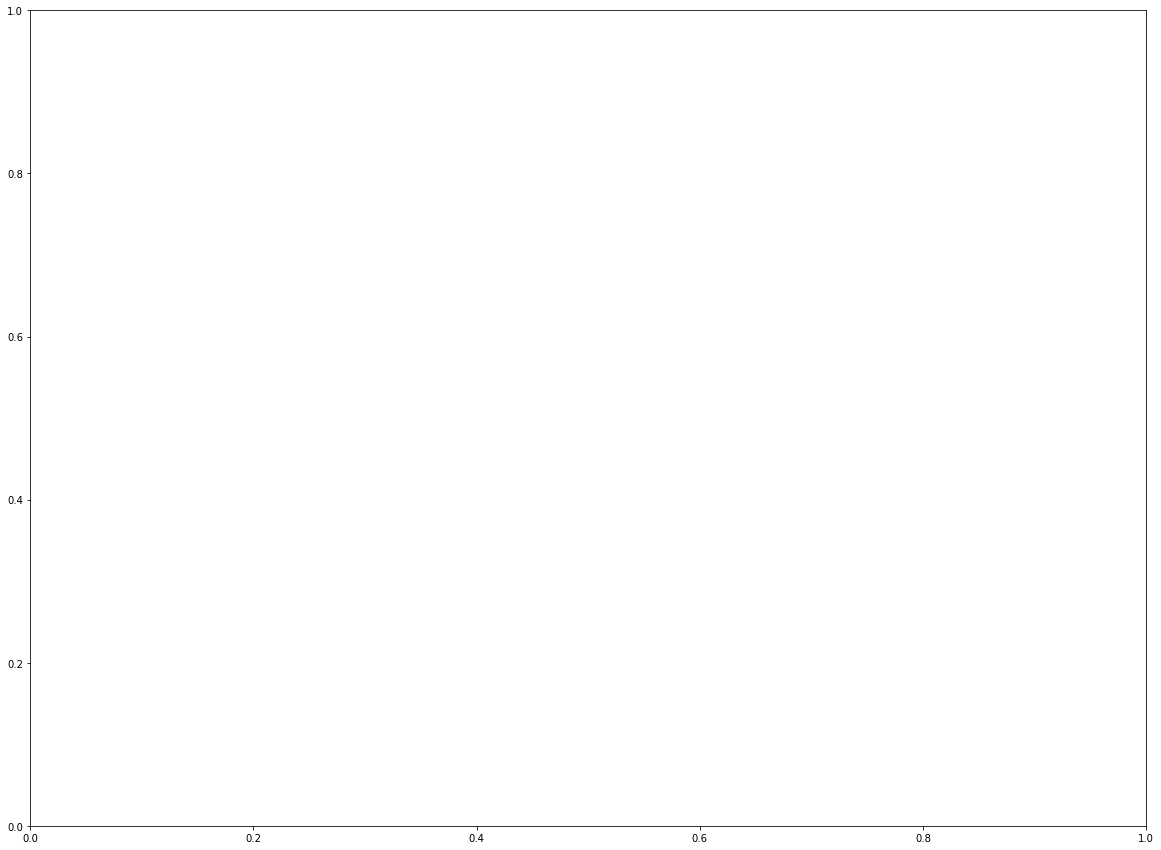

In [39]:
fig=plt.figure(figsize=(20,15))
data.plot(retries=10)

In [ ]:
client.close()

In [ ]:
cluster.close()